In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists
import opendatasets as od
import shutil
import wbgapi as wb

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

import requests
from io import BytesIO

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'olympics_bayes')))
rng = np.random.default_rng(SEED)

# Load Data

Our data is complete for all games since 1960. We are only including Summer Olympics.

In [2]:
df_hosts = pd.read_csv("../Data/clean/hosts_summer.csv", keep_default_na=False)
df_hosts = df_hosts.loc[df_hosts["year"]>=1960]

In [21]:
df_medal_count = pd.read_csv("../Data/clean/medal_count.csv", keep_default_na=False)
df_medal_total = pd.read_csv("../Data/clean/medal_total.csv", keep_default_na=False)
df_medal_pct = pd.read_csv("../Data/clean/medal_pct.csv", keep_default_na=False)
df_won_before = pd.read_csv("../Data/clean/won_before.csv", keep_default_na=False)
df_participant = pd.read_csv("../Data/clean/participant.csv",keep_default_na=False)
df_participant['athletes_pct'] = pd.to_numeric(df['athletes_pct'], errors='coerce')
df_participant['athletes_pct'].fillna(0, inplace=True)
df_gdp = pd.read_csv("../Data/clean/gdp.csv", keep_default_na=False)
df_gdp_pct = pd.read_csv("../Data/clean/pct_gdp.csv", keep_default_na=False)
df_gdp_pc = pd.read_csv("../Data/clean/gdp_pc.csv", keep_default_na=False)

df_pop_pct = pd.read_csv("../Data/clean/pct_pop.csv", keep_default_na=False)

df_free = pd.read_csv("../Data/clean/freedom.csv", keep_default_na=False)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_87108/147409344.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_participant['athletes_pct'].fillna(0, inplace=True)


In [23]:
df = df_participant[["game_id","country_code","participant","athletes_pct"]]
df = pd.merge(df, df_hosts[['game_id','host_country','year']], on='game_id', how='right')
df['host_country'] = np.where(df['country_code'] == df['host_country'], 1, 0)
df = pd.merge(df, df_medal_pct[['game_id','country_code','Gold_pct', 'Silver_pct',
       'Bronze_pct', 'Total_pct']], on=['game_id','country_code'], how='left')
df = df.fillna(0)
df = pd.merge(df, df_gdp[['country_code','gdp','year']], on=['year','country_code'], how='left')
df = pd.merge(df, df_gdp_pct[['country_code','year','pct_gdp']], on=['year','country_code'], how='left')
df = pd.merge(df, df_gdp_pc[['country_code','year','gdp_pc']], on=['year','country_code'], how='left')
df = pd.merge(df, df_pop_pct[['country_code','year','pct_pop']], on=['year','country_code'], how='left')
df = pd.merge(df, df_free[['country_code','year','free']], on=['year','country_code'], how='left')

In [24]:
df[['gdp','pct_gdp','gdp_pc','athletes_pct']] = df[['gdp','pct_gdp','gdp_pc','athletes_pct']].astype(np.float64)

df['free_norm'] = (df['free'] - df['free'].mean()) / df['free'].std()

df = df.loc[df['participant'] == 1]

df[['Gold_pct', 'Silver_pct','Bronze_pct', 'Total_pct']] = 100*df[['Gold_pct', 'Silver_pct','Bronze_pct', 'Total_pct']]

df['country_code'] = df['country_code'].astype(CategoricalDtype())

We will train on all games before Tokyo 2020, and then use those games as our validation for our model.

In [25]:
df_test = df.loc[df["year"] == 2021]
df_train = df.loc[df["year"] < 2021]

## Model

In [39]:
import pytensor.tensor as at
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

COORDS = {'country_code':df_train['country_code'].cat.categories.values, 
          "obs_idx": df_train.index}

with pm.Model(coords=COORDS) as model:
    # Priors for coefficients
    sigma = pm.HalfCauchy("sigma", beta=1)

    alpha_gdp = pm.Normal('alpha_gdp', mu=0, sigma=1)
    alpha_pop = pm.Normal('alpha_pop', mu=0, sigma=1)
    alpha_free = pm.Normal('alpha_free', mu=0, sigma=1)
    alpha_host = pm.Normal('alpha_host', mu=0, sigma=1)
    alpha_athletes = pm.Normal('alpha_athletes', mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    country_effect_mu = pm.Normal('country_effect_mu', 0, 1)
    country_effect_sigma = pm.Gamma('country_effect_sigma', alpha=2, beta=1)
    country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims="country_code")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_sigma * country_effect_offset, dims="country_code")

    gdp = at.as_tensor_variable(df_train['pct_gdp'].values)
    pop = at.as_tensor_variable(df_train['pct_pop'].values)
    free = at.as_tensor_variable(df_train['free_norm'].values)
    host = at.as_tensor_variable(df_train['host_country'].values)
    athletes = at.as_tensor_variable(df_train['athletes_pct'].values)
    medals = at.as_tensor_variable(df_train['Total_pct'].values)

    country_data = pm.Data('country_data', df_train['country_code'].cat.codes.to_numpy(), dims="obs_idx")

    # Define likelihood
    likelihood = (1+alpha_athletes*athletes)*(1 + alpha_host*host)*(intercept + country_effect[country_data] +
        alpha_gdp * 100 * gdp +
        alpha_pop * 100 * pop +
        alpha_free * free)

    y_hat = pm.Normal('y_hat', mu=likelihood, sigma=sigma, observed=medals)
    
    idata = pm.sample(nuts_sampler='nutpie')
    idata = pm.sample_posterior_predictive(idata, 
                                            predictions=True, 
                                            **POST_PRED_KWARGS).assign_coords({"obs_idx":df_train.index})

Sampling: [y_hat]


Output()

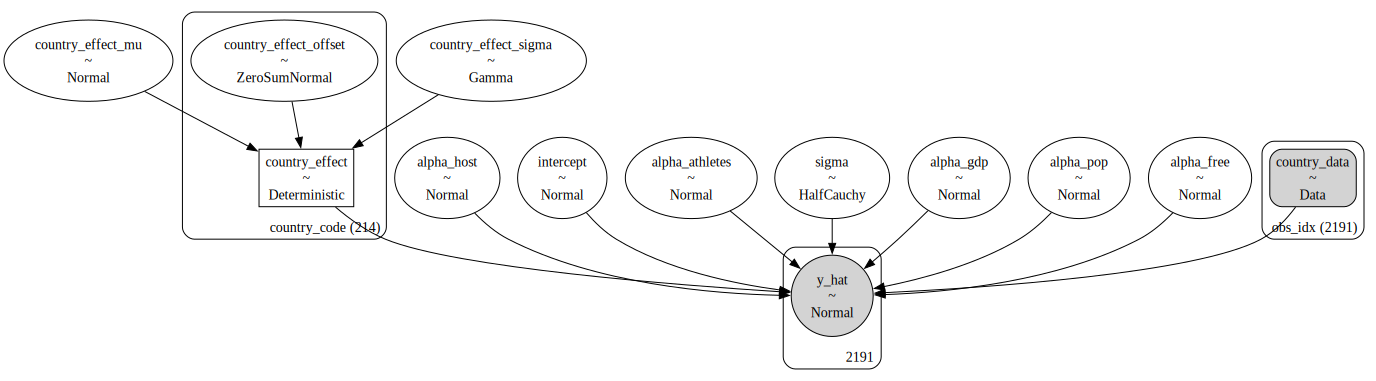

In [40]:
pm.model_to_graphviz(model)

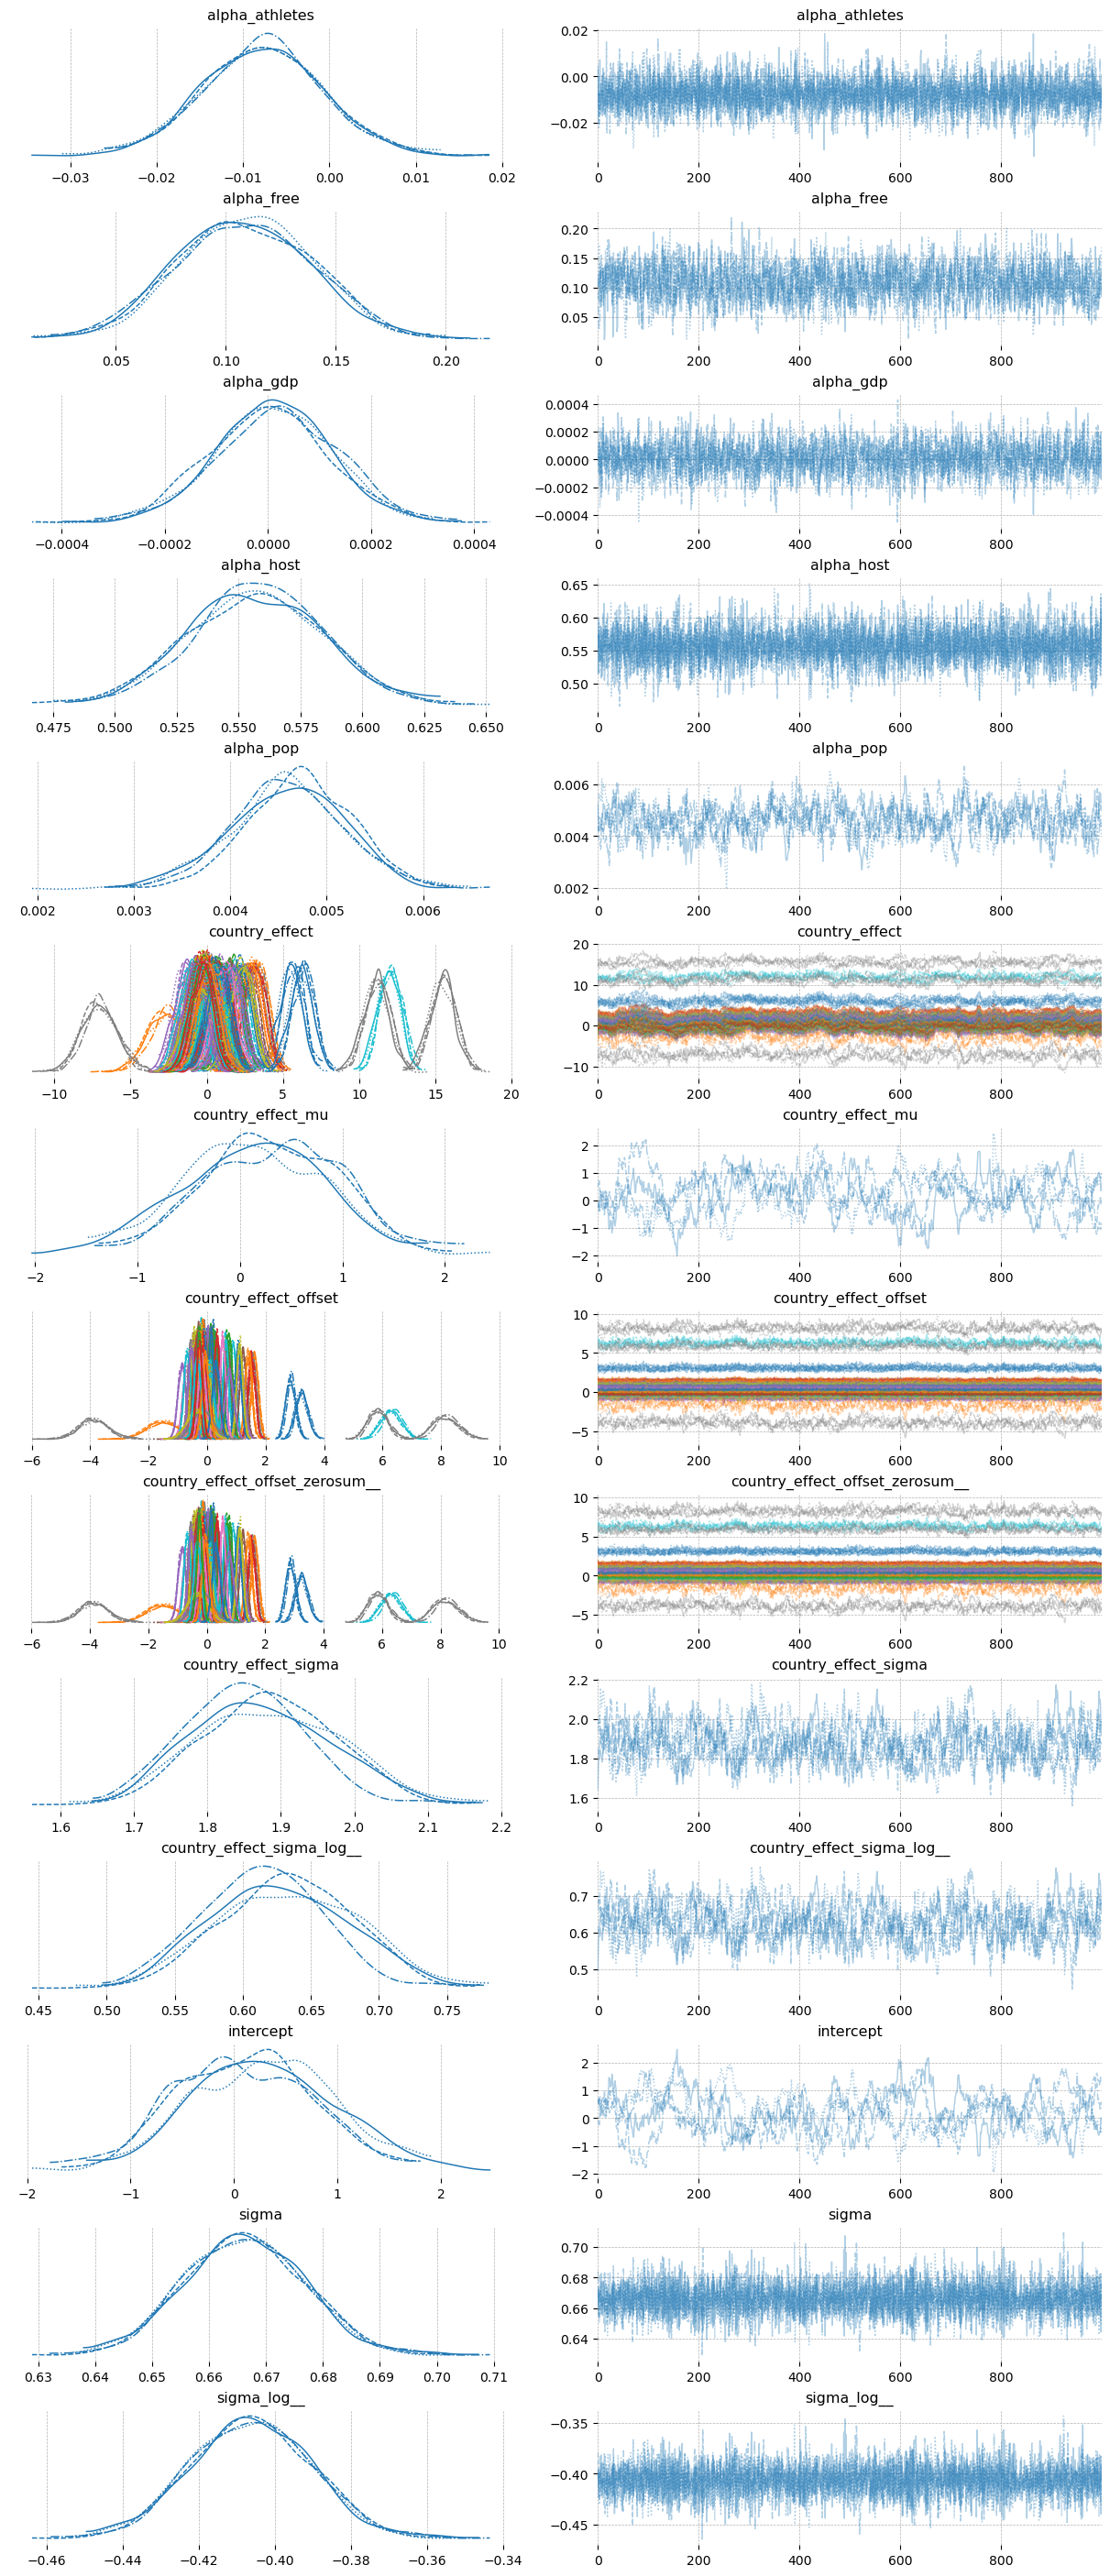

In [41]:
az.plot_trace(idata);

In [42]:
predictions = np.mean(idata.predictions['y_hat'], axis=(0, 1))

In [43]:
hdi_mean = az.hdi(idata.predictions.y_hat)

hdi = pd.DataFrame(hdi_mean['y_hat']).rename(columns={0:'low',1:'high'})

df_train['high'] = hdi['high']
df_train['low'] = hdi['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_87108/4162940493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['high'] = hdi['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_87108/4162940493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['low'] = hdi['low']


In [44]:
hdi_mean_50 = az.hdi(idata.predictions.y_hat, hdi_prob=.5)

hdi_50 = pd.DataFrame(hdi_mean_50['y_hat']).rename(columns={0:'low',1:'high'})

df_train['high_50'] = hdi_50['high']
df_train['low_50'] = hdi_50['low']

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_87108/752352581.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['high_50'] = hdi_50['high']
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_87108/752352581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['low_50'] = hdi_50['low']


In [45]:
df_train['preds'] = predictions

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_87108/1527421163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['preds'] = predictions


In [46]:
df_train['error'] = (df_train['Total_pct'] - df_train['preds'])**2

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_87108/3709973698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['error'] = (df_train['Total_pct'] - df_train['preds'])**2


<Axes: xlabel='Total_pct', ylabel='preds'>

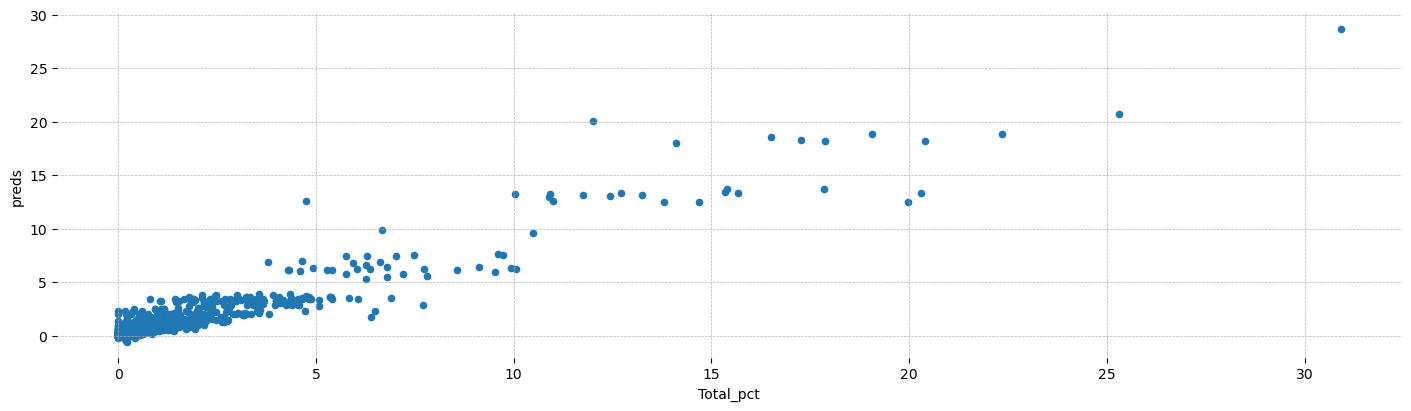

In [47]:
df_train.plot.scatter(x='Total_pct',y='preds')

In [48]:
df_train.loc[df['year']==2016].to_csv("test.csv")

In [49]:
df_train

,game_id,country_code,participant,athletes_pct,host_country,year,Gold_pct,Silver_pct,Bronze_pct,Total_pct,...,gdp_pc,pct_pop,free,free_norm,high,low,high_50,low_50,preds,error
214,rio-2016,AD,1.0,2.087554,0,2016,0.000000,0.000000,0.000000,0.000000,...,39931.216980,0.000923,1.0,-1.310521,1.339410,-1.262049,0.476957,-0.475583,-0.045817,0.002099
216,rio-2016,AR,1.0,0.070466,0,2016,0.977199,0.325733,0.000000,0.411100,...,12790.264140,0.554574,2.0,-0.822541,2.094237,-0.473527,1.262449,0.345647,0.250667,0.025739
217,rio-2016,AT,1.0,0.017616,0,2016,0.000000,0.000000,0.278552,0.102775,...,45307.587862,0.111151,1.0,-1.310521,1.399278,-1.185837,0.569461,-0.347447,0.325995,0.049827
218,rio-2016,AU,1.0,2.973781,0,2016,2.605863,3.583062,2.785515,2.980473,...,49918.793933,0.307766,1.0,-1.310521,1.573957,-1.136728,0.696723,-0.256269,3.415035,0.188844
219,rio-2016,BE,1.0,0.052789,0,2016,0.651466,0.651466,0.557103,0.616650,...,42012.622719,0.144163,1.0,-1.310521,2.186869,-0.327142,1.364605,0.459714,0.464448,0.023165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,rome-1960,VE,1.0,0.000000,0,1960,0.000000,0.000000,0.625000,0.216920,...,939.560806,0.248937,2.0,-0.822541,NaN,NaN,NaN,NaN,0.041041,0.030933
3398,rome-1960,VN,1.0,0.000000,0,1960,0.000000,0.000000,0.000000,0.000000,...,2028.009300,0.998518,4.5,0.397411,NaN,NaN,NaN,NaN,-0.091522,0.008376
3408,rome-1960,SO,1.0,0.000000,0,1960,0.000000,0.000000,0.000000,0.000000,...,62.861994,0.087610,6.5,1.373372,NaN,NaN,NaN,NaN,-0.011250,0.000127
3413,rome-1960,LR,1.0,0.000000,0,1960,0.000000,0.000000,0.000000,0.000000,...,167.538473,0.034700,6.0,1.129381,NaN,NaN,NaN,NaN,0.079496,0.006320
